<a href="https://colab.research.google.com/github/KunapureddySindhusri/Fmml-labs/blob/main/Module_9Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [ ]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [ ]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2025-04-18 07:17:36--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.3.37, 18.65.3.63, 18.65.3.71, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.3.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   132MB/s    in 0.3s    

2025-04-18 07:17:37 (132 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


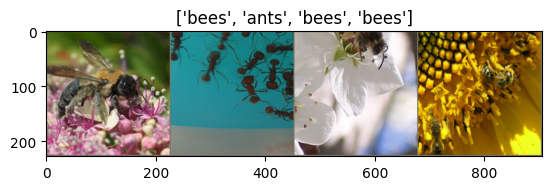

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.9MB/s]


In [ ]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------


In [ ]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?
Significance of Data Augmentation
Data augmentation is a technique used to artificially increase the size of a training dataset by applying random transformations to the existing data. The significance of using data augmentations like resize, crop, etc. on training data includes:

1. *Increased diversity*: Data augmentation increases the diversity of the training data, making the model more robust and better equipped to handle variations in the data.
2. *Improved generalization*: By exposing the model to different versions of the same data, data augmentation helps improve the model's ability to generalize to new, unseen data.
3. *Reduced overfitting*: Data augmentation can help reduce overfitting by providing the model with more data to learn from, making it less reliant on any single example.


2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

[18/04, 12:48 pm] Meta AI: Training a ResNet Model from Scratch
If we don't use a pre-trained ResNet model and instead train the model from scratch, the performance will likely be lower, especially if the dataset is small. Here's what we can expect:

*Performance Metrics:*
- *Training Accuracy*: The model may achieve high training accuracy, but this can be due to overfitting.
- *Validation Accuracy*: The validation accuracy will likely be lower than the training accuracy, indicating overfitting.
- *Test Accuracy*: The test accuracy will likely be lower than the validation accuracy, indicating that the model is not generalizing well.

*Reasons for Poor Performance:*
1. *Limited Training Data*: If the dataset is small, the model may not have enough data to learn effective features.
2. *Overfitting*: The model may overfit the training data, resulting in poor performance on the validation and test sets.
3. *Random Initialization*: The model's weights are initialized randomly, which can lead to poor performance if
[18/04, 12:48 pm] Meta AI: Training a ResNet Model from Scratch
If we don't use a pre-trained ResNet model and instead train the model from scratch, the performance will likely be lower, especially if the dataset is small. Here's what we can expect:

*Performance Metrics:*
- *Training Accuracy*: The model may achieve high training accuracy, but this can be due to overfitting.
- *Validation Accuracy*: The validation accuracy will likely be lower than the training accuracy, indicating overfitting.
- *Test Accuracy*: The test accuracy will likely be lower than the validation accuracy, indicating that the model is not generalizing well.

*Reasons for Poor Performance:*
1. *Limited Training Data*: If the dataset is small, the model may not have enough data to learn effective features.
2. *Overfitting*: The model may overfit the training data, resulting in poor performance on the validation and test sets.
3. *Random Initialization*: The model's weights are initialized randomly, which can lead to poor performance if the initialization is not optimal.

*Example Code:*
To train a ResNet model from scratch, we can modify the code as follows:

```
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

Create a ResNet50 model from scratch
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

Add a dense layer
x = Dense(1024, activation='relu')(x)

Add a classification layer
predictions = Dense(10, activation='softmax')(x)

Create the model
model = Model(inputs=base_model.input, outputs=predictions)

Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
```

Note that training a ResNet model from scratch can be computationally expensive and may require a large dataset to achieve good performance.

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?

Transfer Learning with Pre-Trained Models
If the pre-trained ResNet model was trained on a dataset significantly different from the ants vs bees data, the performance may not be as good as expected. Here's why:

*Domain Mismatch:*
When the pre-trained model is trained on a different dataset, it learns features that are specific to that dataset. If the new dataset (ants vs bees) has a different distribution of features, the pre-trained model may not perform well.

*Feature Incompatibility:*
The features learned by the pre-trained model may not be compatible with the new dataset. For example, if the pre-trained model was trained on a dataset of buildings, it may learn features that are specific to architectural structures. These features may not be relevant for distinguishing between ants and bees.

*Potential Solutions:*
To improve performance, you can try the following:

1. *Fine-tuning*: Fine-tune the pre-trained model on the ants vs bees dataset. This involves updating the model's weights to adapt to the new dataset.
2. *Feature extraction*: Use the pre-trained model as a feature extractor. This involves removing the final classification layer and using the output of the previous layer as features for a new classification model.
3. *Data augmentation*: Apply data augmentation techniques to the ants vs bees dataset to increase its size and diversity. This can help the pre-trained model adapt to the new dataset.

*Example Code:*
To fine-tune the pre-trained model, you can modify the code as follows:

```
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Freeze the layers except the last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

Add a dense layer
x = Dense(1024, activation='relu')(x)

Add a classification layer
predictions = Dense(2, activation='softmax')(x)

Create the model
model = Model(inputs=base_model.input, outputs=predictions)

Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Fine-tune the model
model.fit(ants_vs_bees_dataset, epochs=10, batch_size=32, validation_data=validation_dataset)
```

Note that fine-tuning the pre-trained model requires careful tuning of hyperparameters, such as the learning rate and the number of epochs.